# Robots and kinematics, an overview with python examples

In [1]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

Sources:

https://www.youtube.com/@NorthwesternRobotics

https://robotsdoneright.com/Articles/robot-range-of-motion.html

https://motion.cs.illinois.edu/RoboticSystems/InverseKinematics.html

https://doi.org/10.35313/jitel.v2.i2.2022.139-150

#### Robotics is a science that deals well with robots, but there is much more to that than an arm that moves. There are many things to consider when dealing with robotics, there are velocities, path-finding algorithms, collision-detection algorithms, physics, strength, torque and many more. Today and bear with me here, we will deal with the fundamentals: 
* #### How a robot moves?
* #### What is a joint?
* #### Types of joints
* #### Degrees of freedom
* #### Configuration space
* #### Kinematics

# Most importantly math is fun and i want you to enjoy this little overview and have fun while reading it

![title](robert.jpg)

Source: https://robotics.stackexchange.com/questions/8717/3-degrees-of-freedom-analytical-solution

# 1. Some information about industrial robots and degrees of freedom

### Disclaimer: we will completely ignore physical limitations of our robotic arm. By physical limitations i mean power constraints, weight constraints, motor constraints, material constraints, size of links and joints constraints and many more.

The point is to obtain a simple understanding of the robots movement, the algorithms that **could** stay behind it and the theoretical range of motion.

Robots come in many different shapes and sizes, but the one we will be talking about today is a 3 axis robot, being one of the simpler type of industrial robots. Some of the more complex types include a 6 axis robot that closely resembles the freedom of movements of a human arm.

Now about our 3 axis robot, which we will call quite unoriginally so **Robert**. He has 3 axes, each of which contain a joint of some kind: 

| Axis      | Description | Type of joint     |
| :---        |    :----:   |          ---: |
| Axis 1      | Allows 180° linear rotation around the base       | Revolute   |
| Axis 2   |  Forward and backwards motions of the first link        | Revolute      |
| Axis 3   | Forward and backwards motions of the second link        | Revolute      |

The robots movements have degrees of freedom (DOF). DOF represents the **independent** movements a robotic arm can make, each DOF describes an independent type of motion. 

$dof = \sum_{} \text{ freedom of bodies} - 	\#\text{ of independent constraints}$

$N = \#\text{ of bodies, including ground}$

$J = \#\text{ of joints}$

$m = \text{6 for spatial bodies, 3 for planar bodies}$

There is a table showing us the number of constraints for each joint type:

<img src="constraints.png" alt="drawing" width="400"/>

Source: https://medium.com/@khalil_idrissi/degrees-of-freedom-of-a-robot-c21624060d25

And there is a formula for how they are calculated and its called the Grübler's Equation:

$dof = m(N - 1 - J) + \sum_\limits{i=1}^{J}fi $

Lets apply the formula for our robot. First imagining it in 2D space, ignoring our base joint and the rotation it provides, so we have a 2R robot. Meaning 2 revolute joints robot.

$m = 3, N = 3, J = 2$

$dof = 3(3 - 1 - 2) + 2$

$dof = 2$

Seems logical right, according to the table above we have 2 revolute joints, each with 1 dof. First joint between the ground and the first link and the second between the first and second links.

Now lets move on to 3D space and calculate the dof. We have a link between the ground and the first joint (the rotating base), ergo $N$ is increased by 1, even if that link length is 0. 

$m = 6, N = 4, J = 3$

$dof = 6(4 - 1 - 3) + 3$

$dof = 3$

3 revolute joints in 3D space give us a degree of freedom equal to 3.

Fun fact: humans have 36 DOF, but we obviously are severly limited in terms of their angles  
<img src="dof.jpg" alt="Drawing" style="width: 200px;"/>


# 2. Configuration space (C-space)


The configuration space of a robot is a representation of all possible positions and orientations that the robot can achieve. For Robert, the configuration space provides a way to visualize and analyze the possible configurations of the robot in terms of its joint angles. To put it simply it tells us **where the robotic arm is**. Not to be mistaken with **workspace** which describes all the possible positions of the *useful* part of the robot (end-effector), in the case of Robert its the end of the second link, where purely in our imagination we can attach some kind of tool, be it a gripper, welder, cutter, sensor or something of the sort. 

In 2D space ignoring the base - the configuration space is every possible combination of angles between the ${X}$ axis and the first link, which we will call ${\theta}_1$ and every possible combination of angles between an imaginary extension of the first link and the second link which we will call ${\theta}_2$. You have to keep in mind that this is the case for **revolute** joints, since revolute joints can be looked at as hinges in their neutral state and hinges have one angle value to represent them, a hinge opened $0{\degree}$ means its closed and vice versa - a hinge opened $180{\degree}$ is fully open. Execute the code below to get a visual representation of the angles and links. The orange circles represent all infinite number of joint angles.

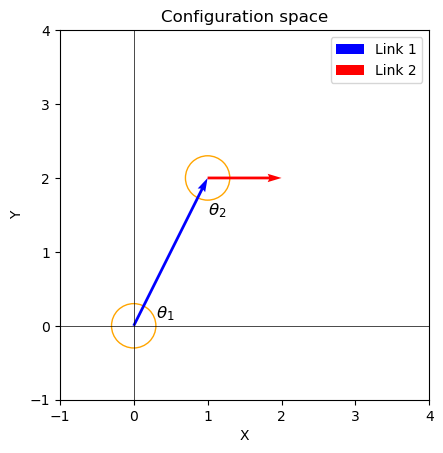

In [2]:
# The links and their x,y values
vector1 = np.array([1, 2])
vector2 = np.array([1, 0])

# Plotting the links
circle1 = plt.Circle((0, 0), radius=0.3, color='orange', fill=False)
circle2 = plt.Circle((vector1[0],vector1[1]), 0.3, color='orange', fill=False)

fig, ax = plt.subplots()
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.quiver(0, 0, vector1[0], vector1[1], angles='xy', scale_units='xy', scale=1, color='b', label='Link 1')
ax.quiver(1, 2, vector2[0], vector2[1], angles='xy', scale_units='xy', scale=1, color='r', label='Link 2')

# Angle labels
plt.text(0.3, 0.1, r'${\theta}_1$', fontsize=12)
plt.text(1, 1.5, r'${\theta}_2$', fontsize=12)


# Plot beautifying
plt.xlim(-1, 4)
plt.ylim(-1, 4)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Configuration space')
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)

plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


So lets ignore the second link and ${\theta}_2$ making our robot a 1 ${dof}$ and look at the C-space (${C}$) of the first link for a second, pretty obviously it is $360{\degree}$ (a circle - ${S^1}$) and since mathematicians are evil we will use radians from now on and that means the configurations space is $2{\pi}$.

For 1 ${dof}$ robot  ${C_{1dof} = S^1}$

Now lets stop ignoring the second link and we get a C-space of 2 circles.

For 2 ${dof}$ robot  ${C_{2dof} = S^1 \cdot S^2}$

After pieceing up poor Robert we can see that his C-space describes a circle around another circle - donut (for the math nerds - a **torus**) in **2D** space with his 2${dof}$

![title](donut.png)

Source: https://en.wikipedia.org/wiki/Torus

How many ${dof}$ did he have in 3D space? Three so we get this:

For 3 ${dof}$ robot  ${C_{3dof} = S^1 \cdot S^2 \cdot S^3}$

This is a 3-dimensional torus - dont try to imagine it.

Execute the code below and try focusing on the angles and letting that sink in, the workspace of our friend is also shown but it doesn't concern us for now.

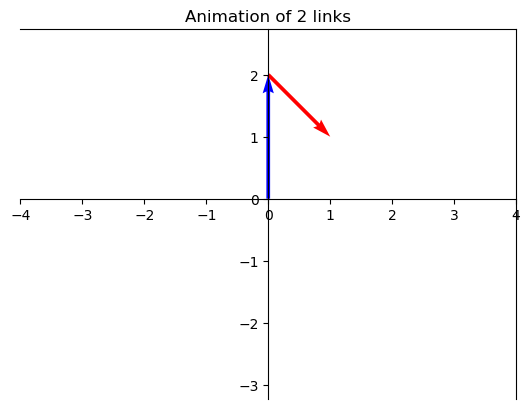

In [3]:
def rotate_vector(vector, angle_deg):
    # From degrees to radians
    angle_rad = math.radians(angle_deg)
    x, y = vector
    
    # Coordinates after rotation
    new_x = x * math.cos(angle_rad) - y * math.sin(angle_rad)
    new_y = x * math.sin(angle_rad) + y * math.cos(angle_rad)

    return new_x, new_y
# Create a figure and a line object
fig, ax = plt.subplots()
vectors = np.array([[0.0,0.0,2.0,0.0], [0.0, 0.0, 1.0, 1.0]])
X, Y, U, V = vectors[:, 0], vectors[:, 1], vectors[:, 2], vectors[:, 3]
X, Y, U, V = vectors[:, 0], vectors[:, 1], vectors[:, 2], vectors[:, 3]
colors = [ 'blue','red']

for frame in range(90):
    U,V = rotate_vector([U, V], 5)
    # Assign second vector initial point
    X[1] = U[0]
    Y[1] = V[0]
    U[1],V[1] = rotate_vector([U[1], V[1]], 10)
    # Plotting
    line = ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', color=colors, scale=1)
    # Clearing for kind of animation
    ax.relim() 
    clear_output(wait=True)
    display(fig)
    ax.cla()

    # Make it nice
    ax.set_xlim([-4, 4])
    ax.set_ylim([-5.5, 5])
    ax.spines["bottom"].set_position("zero")
    ax.spines["left"].set_position("zero")
    ax.axis('equal')
    plt.title('Animation of 2 links')

plt.close()  # Close figure when done


### Disclaimer: for rotations and general movement its an industry standard to use matrices, for this perticular plot i used radians.

## Why is this important?

Before moving on to 3D and kinematics i feel like it's important to grasp the concept and understand the fundamentals of robotics. 
Our understanding of C-space is crucial for inverse kinematics, motion planing, collision detection and much more.


# 3. Kinematics
![title](pooh.jpg)

### Kinematics is a branch of physics that deals with motion, but without considering the force that realizes that movement. Fundamentally its about how fast something moves, how it speeds up and how fast it is. In our case it is pretty closelsy related to the end-effector position. To imagine it just move your fist in space and think about the speed, position and how much slower/faster you can move it.

There are some complicated kinematic stuff like trajectory planning and paths but i have no idea how to do that so we are gonna stick to the basics for now. Kinematics are very closely related to matrices, every link represents some kind of a translation matrix and every revolute joint represents a rotation matrix. How does this all come together? Since we are talking about 3D space **IN OUR CASE** we can represent every joint-link combo as seperate frames and a frame is essentialy a cartesian system which originates from the center of the joint. 

There are some rules for the frame assignments:

The $Z$ axes for revolute joints should correspond to the angle of rotation axes, note the MS Paint™ image below the $Z_{2|3}$ axes align with the axis of rotation the joints are rotationg around the $Z$ axis. The $Z_3$ axis for our static gripper does not matter but since we can reduce some calculations if we match it up with the existing ones it corresponds to the last frame with axes $X_2 | Y_2 | Z_2$.

The $X$ axes should point from the frame origin to the next joint, example - $X_2$ pointing towards the end-effector. And if $Z$ axes intersect the $X$ one should be normal to the plane of the one before, note $Z_0$ and $Z_1$ and how $X_0$ and $X_1$ are **NOT** paralell, that is something that we will have to solve with a rotation.

The $Y$ axes are set according to the right hand rule, point the thumb towards the $Z$ axis, the fingers towards the $X$ and the palm should point towards the $Y$.

Sorry for the terrible drawing :^)

![title](FramesRobert1.png)

### Denavit–Hartenberg parameters (DH parameters) - 4 parameters that describe how our frames are attached according to a convention. They are:  
* $r_i$ ​ : Link length (distance between $Z_i$ ​ and $Z_{i+1}$ ​ along $X_i$ ​ )  
* ${\alpha_i}$ : Link twist (angle between $Z_i$ ​ and $Z_{i+1}$ ​ about $X_i$ ​ ) (Try avoiding these)
* $d_i$  : Link offset (distance between $X_i$ ​ and $X_{i+1}$ ​ along $Z_i$ ​ )
* ${\theta_i}$ ​ : Joint angle (angle between $X_i$ ​ and $X_{i+1}$ ​ about $Z_i$ ​ )  

With revolute and prismatic joints 3 of these parameters are always constants, for revolute joints the constant parameters are $d$,$r$ and $\alpha$ and for prismatic joints $\theta$, $r$ and $\alpha$.

![title](params.png)

Source: https://prajankya.me/dh/

So how does a DH paramater table look, well like this:

<img src="table-example.jpg" alt="drawing" width="400"/>

Source: https://automaticaddison.com/homogeneous-transformation-matrices-using-denavit-hartenberg/

Lets try making one for our beautiful example. I will walk you through with joint $1$. 

First is the $d_1$ parameter, look at the normal axis - $X_{1|2}$ about the $Z_0$ axis and you get the length of $d_1$ equivalent to $L_1$

Second the ${\alpha_1}$ angle, lets look again at the example, focusing on $Z_0$ and $Z_1$ along the $X_1$ axis, by the right hand rule if we rotate it $90\degree$ along the $X$ axis we will normalize it.

Third one: $r_1$ - about $X_0$ look at the distance between $Z_0$ and $Z_1$, its 0 as well. Again the $Z_0$ axis of the frame continues indefinitely.

These were our constants, in revolute/prismatic joints there are always 3 constants and 1 variable.

Foruth one: $\theta_1$ - the angle between $X_0$ and $X_1$, in our example its 0 but consider the rotating base, $X_1$ will move along with it, so the angle is variable that we label $\theta_1$

| Joint i | ${\theta_i}$ (angle) | ${\alpha_i}$ (angle)     | $r_i$ (length)    | $d_i$ (length)    |
| :---    |    :----:            |     :---:                |         ---:      |          ---:     |
| 1       |   $\theta_1$         | ${90\degree}$            | 0                 | $L_1$              |
| 2       |   $\theta_2$         | 0                        | $L_2$             | 0                 |
| 3       |   $\theta_3$         | 0                        | $L_3$             | 0                 |


Thats our DH table, you should be able to understand what the values mean and how are they calculated. Based on this table we will construct our transformation matrix for forward kinematics.

>

# 3.1. Forward Kinematics (FK)
### Used to obtain the end-effector position position from the parameters of the joints and links

To do that we must move from the first frame to the last frame, by applying the apporpirate transformations, a transformation from frame $0$ to frame $1$, from frame $1$ to frame $2$ etc. To find the transformation that describes going from frame $0$ to the end-effector frame $3$ we have to use this formula:

$\prescript{0}{n}{T} = \prescript{0}{1}{T}  \cdot  \prescript{1}{2}{T}  \cdot  \prescript{2}{3}{T} ... \prescript{n-1}{n}{T}$

And to get each transformation we use this one, **IN THIS EXACT ORDER**:

$\prescript{i-1}{i}{T} = R_z(\theta_i) \cdot D_z(d_i) \cdot D_x(r_{i-1})  \cdot  R_x(\alpha_{i-1})$

$R$ stands for rotation matrix and $D$ for translation.

Lets construct our rotation matrices, i trust you know what a matrix is:

$$\prescript{0}{1}{T} = R_z(\theta_1) \cdot D_z(L_1) \cdot R_x(90\degree) = 
\begin{bmatrix}
\cos(\theta_1) & -\sin(\theta_1) &        0        & 0\\\
\sin(\theta_1) &  \cos(\theta_1) &        0        & 0\\ 
       0       &         0       &        1        & 0 \\ 
       0       &         0       &        0        & 1 \\
\end{bmatrix} \cdot
\begin{bmatrix}
       1       &         0       &        0        & 0\\\
       0       &         1       &        0        & 0\\ 
       0       &         0       &        1        & L1 \\ 
       0       &         0       &        0        & 1 \\
\end{bmatrix} \cdot 
\begin{bmatrix}
       1       &         0       &        0        & 0\\\
       0       &         0       &       -1        & 0\\ 
       0       &         1       &        0        & 0 \\ 
       0       &         0       &        0        & 1 \\
\end{bmatrix}
= \begin{bmatrix}
    \cos(\theta_1)       &         0             &        \sin(\theta_1)        & 0\\\
    \sin(\theta_1) &         0                   &       -\cos(\theta_1)     & 0\\ 
       0           &         1                   &           0               & L1 \\ 
       0           &         0                   &           0               & 1 \\
\end{bmatrix}
$$

$$\prescript{1}{2}{T} = R_z(\theta_2) \cdot D_x(L2) = 
\begin{bmatrix}
\cos(\theta_2) & -\sin(\theta_2) &        0        & 0\\\
\sin(\theta_2) &  \cos(\theta_2) &        0        & 0\\ 
       0       &         0       &        1        & 0 \\ 
       0       &         0       &        0        & 1 \\
\end{bmatrix} \cdot
\begin{bmatrix}
       1       &         0       &        0        & L2\\\
       0       &         1       &        0        & 0\\ 
       0       &         0       &        1        & 0 \\ 
       0       &         0       &        0        & 1 \\
\end{bmatrix}=
\begin{bmatrix}
\cos(\theta_2) & -\sin(\theta_2) &        0        & L2\cos(\theta_2)\\\
\sin(\theta_2) &  \cos(\theta_2) &        0        & L2\sin(\theta_2)\\ 
       0       &         0       &        1        & 0 \\ 
       0       &         0       &        0        & 1 \\
\end{bmatrix}
$$

$$\prescript{2}{3}{T} = R_z(\theta_3) \cdot D_x(L3) = 
\begin{bmatrix}
\cos(\theta_3) & -\sin(\theta_3) &        0        & 0\\\
\sin(\theta_3) &  \cos(\theta_3) &        0        & 0\\ 
       0       &         0       &        1        & 0 \\ 
       0       &         0       &        0        & 1 \\
\end{bmatrix} \cdot
\begin{bmatrix}
       1       &         0       &        0        & L3\\\
       0       &         1       &        0        & 0\\ 
       0       &         0       &        1        & 0 \\ 
       0       &         0       &        0        & 1 \\
\end{bmatrix}=
\begin{bmatrix}
\cos(\theta_3) & -\sin(\theta_3) &        0        & L3\cos(\theta_3)\\\
\sin(\theta_3) &  \cos(\theta_3) &        0        & L3\sin(\theta_3)\\ 
       0       &         0       &        1        & 0 \\ 
       0       &         0       &        0        & 1 \\
\end{bmatrix}
$$

And finally to get the transformation matrix that shows you the position of the end-effector:  
$$\prescript{0}{3}{T} = \prescript{0}{1}{T} \cdot \prescript{1}{2}{T} \cdot \prescript{2}{3}{T}$$

$$
\prescript{0}{3}{T} = \begin{bmatrix}
c(\theta_1)c(\theta_2)c(\theta_3) - c(\theta_1)s(\theta_2)s(\theta_3) & -c(\theta_1)c(\theta_2)s(\theta_3)-s(\theta_1)c(\theta_2)c(\theta_3) & s(\theta_1) & L_3c(\theta_1)c(\theta_2)c(\theta_3) - L_3c(\theta_1)s(\theta_2)s(\theta_3) + L_2c(\theta_1)c(\theta_2) \\
s(\theta_1)c(\theta_2)c(\theta_3) + s(\theta_1)c(\theta_2)s(\theta_3) & -s(\theta_1)c(\theta_2)s(\theta_3)-s(\theta_1)c(\theta_2)c(\theta_3) & -c(\theta_1) & L_3s(\theta_1)c(\theta_2)c(\theta_3) - L_3s(\theta_1)c(\theta_2)s(\theta_3) + L_2c(\theta_1)c(\theta_2) \\
s(\theta_2)c(\theta_3) + c(\theta_2)s(\theta_3) & -s(\theta_2)s(\theta_3) + c(\theta_2)c(\theta_3) & 0 & L_3s(\theta_2)c(\theta_3) + L_3c(\theta_2)s(\theta_3) + L_1 + L_2s(\theta_2) \\
0 & 0 & 0 & 1 
\end{bmatrix}
$$

<center><img src="sherMeme.jpg"/></center>

The code below showcases the transformations, execute it.

In [4]:
# This is literally the T from 0 to 1 in code it is the exact same thing.
def transformation_frame_1(theta1, L1):
    theta1 = np.radians(theta1)
    # 90 degrees rotation matrices are rather simple to fill out 
    rotationX     =      np.array([  [  1.0,               0.0,                0.0,              0.0],
                                     [  0.0,               0.0,               -1.0,              0.0],
                                     [  0.0,               1.0,                0.0,              0.0],
                                     [  0.0,               0.0,                0.0,              1.0]])
    
    rotationZ     =      np.array([  [  np.cos(theta1), -np.sin(theta1),       0.0,              0.0],
                                     [  np.sin(theta1),  np.cos(theta1),       0.0,              0.0],
                                     [  0.0,               0.0,                1.0,              0.0],
                                     [  0.0,               0.0,                0.0,              1.0]])

    translationZ  =      np.array([  [  1.0,               0.0,                0.0,              0.0 ],
                                     [  0.0,               1.0,                0.0,              0.0 ],
                                     [  0.0,               0.0,                1.0,            float(L1) ],
                                     [  0.0,               0.0,                0.0,              1.0 ]])

    T1 = np.dot(rotationZ, translationZ);
    return np.dot(T1, rotationX)

def transformation_frame_2(theta2, L2):
    theta2 = np.radians(theta2)
    rotationZ2     =      np.array([ [  np.cos(theta2), -np.sin(theta2),       0.0,              0.0],
                                     [  np.sin(theta2),  np.cos(theta2),       0.0,              0.0],
                                     [  0.0,               0.0,                1.0,              0.0],
                                     [  0.0,               0.0,                0.0,              1.0]])
    
    translationX2  =      np.array([ [  1.0,               0.0,                0.0,           float(L2) ],
                                     [  0.0,               1.0,                0.0,              0.0 ],
                                     [  0.0,               0.0,                1.0,              0.0 ],
                                     [  0.0,               0.0,                0.0,              1.0 ]])
    
    return np.dot(rotationZ2, translationX2)

def transformation_frame_3(theta3, L3):
    theta3 = np.radians(theta3)
    rotationZ3     =      np.array([ [  np.cos(theta3), -np.sin(theta3),       0.0,              0.0],
                                     [  np.sin(theta3),  np.cos(theta3),       0.0,              0.0],
                                     [  0.0,               0.0,                1.0,              0.0],
                                     [  0.0,               0.0,                0.0,              1.0]])
    
    translationX3  =      np.array([ [  1.0,               0.0,                0.0,           float(L3) ],
                                     [  0.0,               1.0,                0.0,              0.0 ],
                                     [  0.0,               0.0,                1.0,              0.0 ],
                                     [  0.0,               0.0,                0.0,              1.0 ]])

    return np.dot(rotationZ3, translationX3)

def forward_kinematics_calculation(theta1, theta2, theta3, L1, L2, L3):
    T1 = transformation_frame_1(theta1, L1)
    T2 = transformation_frame_2(theta2, L2)
    T3 = transformation_frame_3(theta3, L3)
    T0_2 = np.dot(T1, T2)

    T0_3 = np.dot(T0_2, T3)
    return np.round(T0_3, 2);

### After determining our transformation matrices we can move on to some demos, the code below will show you what forward kinematics are all about. Execute it and move on to the demos!

In [5]:
def axisBeautify(ax, title):
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_zlim([0, 2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    return ax
    
def plot_vectors_forward_kinematics(theta1, theta2, theta3, L1, L2, L3, title, ef_position=False):
    # Origin
    origin = [0,0,0,1]
    # Coordinates first link
    T1 = forward_kinematics_calculation(theta1, 0, 0, L1, 0, 0)
    O1 = T1[:3, 3]
    x1, y1, z1 = O1[0], O1[1], O1[2]

    # Coordinates second link
    T2 = forward_kinematics_calculation(theta1, theta2, 0, L1, L2, 0)
    O2 = T2[:3, 3]
    x2, y2, z2 = O2[0], O2[1], O2[2]
    
    # Coordinates third link
    T3 = forward_kinematics_calculation(theta1, theta2, theta3, L1, L2, L3)
    O3 = T3[:3, 3]
    x3, y3, z3 = O3[0], O3[1], O3[2]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot origin
    ax.scatter(0, 0, 0, color='k', s=30, label='Origin 0')
    # Plot links
    ax.plot([0, x1], [0, y1], [0, z1], color='r', label='Link 1')
    ax.plot([x1, x2], [y1, y2], [z1, z2], color='b', label='Link 2')
    ax.plot([x2, x3], [y2, y3], [z2, z3], color='g', label='Link 3')

    # Plot end-effector origin
    ax.scatter(x3, y3, z3, color='orange', s=30, label='End-ef')
    if(ef_position):
        print('End ef:')
        print(x3, y3, z3)
    axisBeautify(ax, title)
    ax.legend()
    plt.show()
    
def plot_moved_origin_FK(theta1, theta2, theta3, L1, L2, L3, title):
    T = forward_kinematics_calculation(theta1, theta2, theta3, L1, L2, L3)
    origin = [0, 0, 0, 1] # This is the origin of frame 0
    origin = np.dot(T, origin) # With this transformation we are moving it to the origin of the last frame
    origin = np.delete(origin, 3) # Remove the part for homogenization

    vector = np.append([0,0,0], origin) # Add a beginning of our vector and plot it to the end effector origin
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.quiver(vector[0], vector[1], vector[2], vector[3], vector[4], vector[5], pivot='tail')
    
    ax.scatter(0, 0, 0, color='k', s=30, label='Origin 0')
    ax.scatter(vector[3], vector[4], vector[5], color='orange', s=30, label='Origin 3')
    ax.legend()
    axisBeautify(ax, title)
    plt.show()

Using the above-mentioned functions we can now play a bit with our forward kinematics, i have selected a few random examples but go ahead and experiment. Be aware with the link sizes since the i have limited the plot.

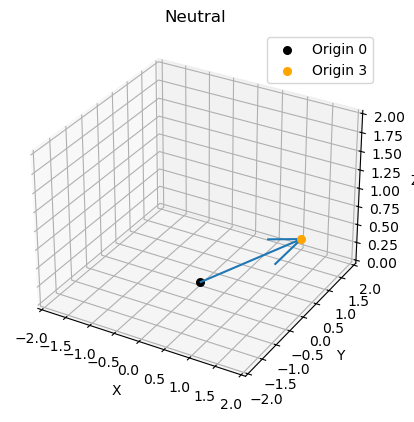

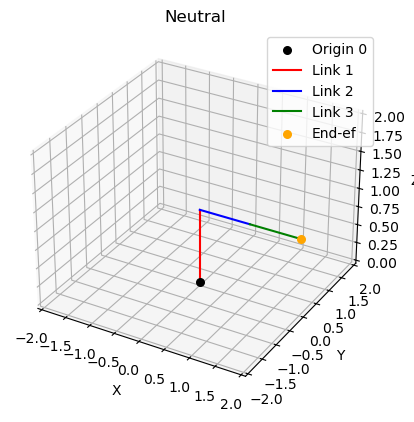

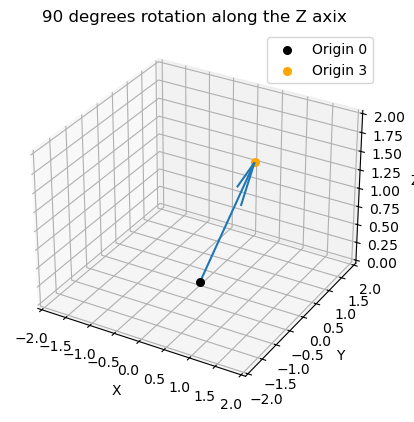

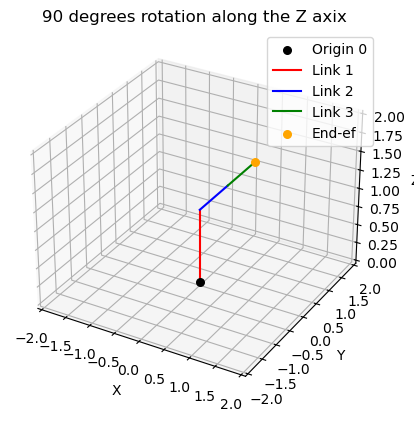

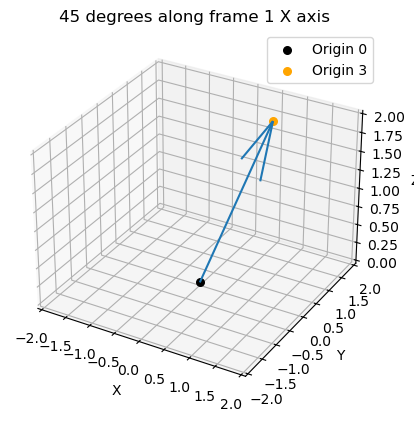

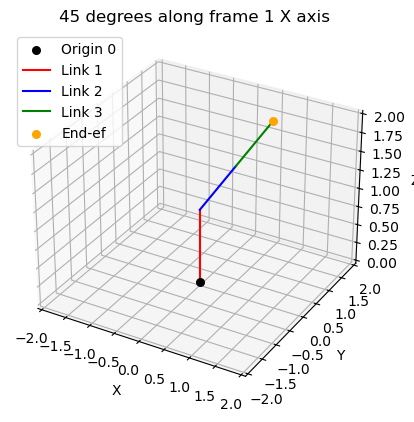

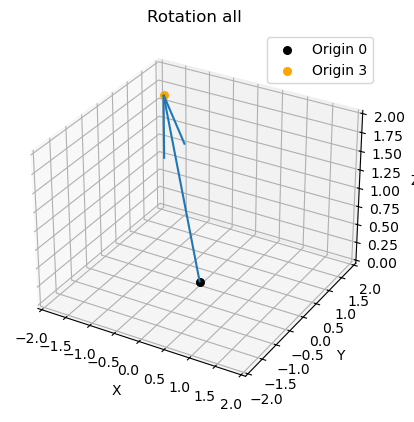

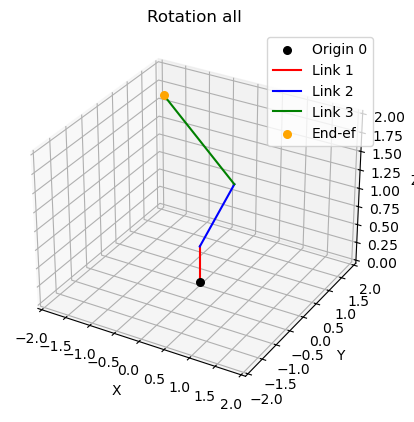

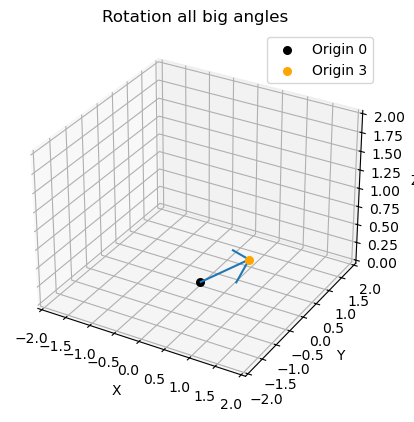

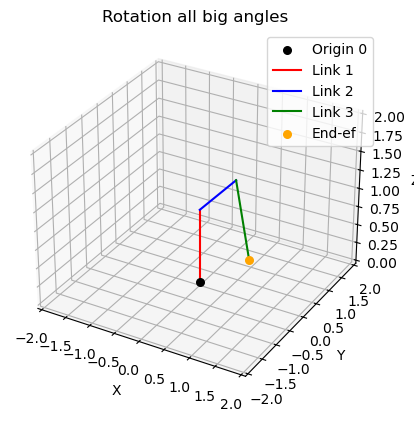

In [6]:
# Play with theese to understand how our origin is moved
plot_moved_origin_FK(0, 0, 0, 1, 1, 1, 'Neutral')
plot_vectors_forward_kinematics(0, 0, 0, 1, 1, 1, 'Neutral')

plot_moved_origin_FK(90, 0, 0, 1, 1, 1, '90 degrees rotation along the Z axix') # Rotation of the whole robot by 90 degrees along the Z axis
plot_vectors_forward_kinematics(90, 0, 0, 1, 1, 1, '90 degrees rotation along the Z axix')

plot_moved_origin_FK(0, 45, 0, 1, 1, 1, '45 degrees along frame 1 X axis')# Rotation of the first link by 45 degrees along frame 1 X axis
plot_vectors_forward_kinematics(0, 45, 0, 1, 1, 1, '45 degrees along frame 1 X axis')

plot_moved_origin_FK(60, 45, 90, 0.5, 1, 2, 'Rotation all')# Rotation of the first link by 45 degrees along frame 1 X axis
plot_vectors_forward_kinematics(60, 45, 90, 0.5, 1, 2, 'Rotation all')

plot_moved_origin_FK(140, 150, 80, 1, 2, 1, 'Rotation all big angles')# Rotation of the first link by 45 degrees along frame 1 X axis
plot_vectors_forward_kinematics(140, 150, 80, 1, 2, 1, 'Rotation all big angles')

You can hopefully understand what forward kinematics are all about.

# 3.2 Inverse Kinematics (IK)

### Used to obtain the joint angles from the end-effector position

![title](ikVsFk.jpg)

Onto inverse kinematics, this in my opinion is the most interesting part of our how-to. Inverse kinematics is a process which determines the joint angles from the end-effector position. Think about our previous plots if our neutral plot was $\theta_{1|2|3} = 0$ and $L_{1|2|3} = 1$, then the coordinates of its end effector were $[2, 0, 1]$. What if we wanted to determine the angles of the joints $\theta_{1-n}$ by the end-effector position? Thats where inverse kinematics come into play, their calculation gives us exactly that BUT with **some error**. Some general stuff about IK:  
* In IK you may have infinite amount of solutions if the $dof$ of a manipulator are more than the coordinates representing the desired end-effector position. If for example we have a chain link system with a lot of revolute joints we can have many combinations of joint angles that approach the desired position.
* There are a dozen ways to calculate the IK of a manipulator, they boil down to **analytical** solution for simpler manipulators and **numerical** solution for more complex ones. Many real life examples combine both.  
* You may not have a solution if for example the desired position is outside the workspace of the manipulator. In the case of a numerical solution its a question whether the position will converge since it is reliant on methods that are closely related to calculus.

Let's determine how many solutions exist for the IK of Robert.  
$dof$ - degrees of freedom (i hope you remember that)  
$c$ - number of constraints (in our case the number of coordinates that describe the end-effector position)   

Following these rules:  
* $dof < c$ - overconstrained system, no solution exists. We cannot bend the configuration space to make a $2dof$ manipulator reach a spatial point
* $dof = c$ - finite number of solutions.
* $dof > c$ - underconstraineed system, infinite number of solutions or no solutions. Also called redudancy and the manipulator - redundant.

So lets see how many solutions we have:  
$dof = 3,  c = 3$  
$dof = c$  
Finite number of solutions. In our case almost always 2 since there are 2 ways of approaching a point, once from _above_ and once from _below_.

### 3.2* Analytical IK

Now that we have determined what IK are, lets talk about our approach. We have a rather simple system so it would be best to use an analytical solution, meaning we will use trigonomotry, algebra and our FK solution to solve it. How shall we look at our robot for everything to boil down to this? Once from above and once from the side of course, as simple as that. Look at the figure below, we basically boil down our spatial coordinates and configuration space to planar.

![title](test.png)
Source: https://jitel.polban.ac.id/jitel/article/view/101

Lets talk math! We are given the $L_{1|2|3}$ parameters, lets figure out the rest.

* $r_1$ is really easy - since we are not accounting for a value about the $Z$ axis its the distance between $[0, 0, 1]$ (the base) and $[x_{desired}, y_{desired}, 1]$  we use the Pythagorean theorem ignoring the $Z$ values:  
    $$r_1 = \sqrt(x_d - 0) + (y_d - 0)$$
* $r_2$ - We subtract $L_1$ from $z_{desired}$ and thats it.
    $$r_2 = z_{d} - L_1 $$
* $r_3$ - Pythagorean theorem once again  
    $$r_3 = \sqrt(r_1^2 + r_2^2) $$
  
Thats it for the lengths of our triangle, now to the angles!

* $\theta_1$ - the angle of the base
    $$\theta_1 = \arctan({y_d \over x_d}) $$
* $\theta_2$ - the angle of the first link, composed of two other angles $\phi_1$ and $\phi_2$, for the second one we use the Law of Cosines. To determine both solutions we take one to the left and one to the right of $r_3$
    $$\phi_1 = \arctan({r_2 \over r_1})$$
    $$\cos(\phi_2) = {L_2^2 + r_3^2 - L_3^2 \over 2 \cdot L_2 \cdot r_3}$$
    $$\phi_2 = \arccos({L_2^2 + r_3^2 - L_3^2 \over 2 \cdot L_2 \cdot r_3}) $$
    $$\theta_2 = \phi_1 \pm \phi_2$$
* $\theta_3$ - angle of the second link and since we are looking at the angle between the continuation of the $L_2$ we substract or add with $180\degree$ to get both solutions
    $$ \theta_3 = 180 \pm \arccos({L_2^2 + L_3^2 - r_3^2 \over 2 \cdot L_2 \cdot L_3})$$

Execute the code below, this is the function for IK computation.

In [8]:
def inverse_kinematics_3R(x_d, y_d, z_d, L1, L2, L3):
    # Step 1: Compute q1
    q1 = np.arctan2(y_d, x_d)
    
    # Step 2: Compute r distances
    r1 = np.linalg.norm(np.array((x_d, y_d)) - np.array((0, 0)))
    r2 = z_d - L1
    r3 = np.sqrt(r1 ** 2 + r2 ** 2)

    # Determine the longer and shorter links so we can see if we have a solution
    longer_link = L3 if L2 < L3 else L2
    shorter_link = L3 if L2 > L3 else L2

    # Check if a solution exists
    if(r3 > L2 + L3 or r3 < longer_link - shorter_link):
        raise Exception('Desired position out of worskpace. No solution exists')
        return

    # Phi 1 
    phi1 = np.arctan2(r2, r1)

    # Phi 2 split for easier understanding
    x1 = (L2 ** 2 + r3 ** 2 - L3 ** 2) / (2 * L2 * r3)
    phi2 = np.arccos(x1)

    # Phi 3
    x2 = (L2 ** 2 + L3 ** 2 - r3 ** 2) / (2 * L2 * L3)
    phi3 = np.arccos(x2)
    
    # Convert to degrees
    q1_deg = np.degrees(q1)
    q2_IK1_deg = np.degrees(phi1 - phi2)
    q2_IK2_deg = np.degrees(phi1 + phi2)
    q3_IK1_deg = 180 - np.degrees(phi3)
    q3_IK2_deg = 180 + np.degrees(phi3)
    
    return q1_deg, q2_IK1_deg, q3_IK1_deg, q1_deg, q2_IK2_deg, q3_IK2_deg

To the demos! Play with the functions below and possibly break the code!

End ef:
0.0 -1.1 0.85


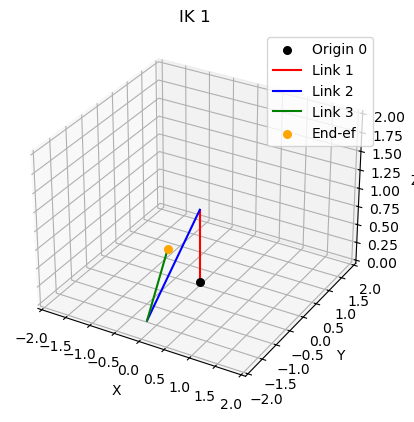

End ef:
0.0 -1.1 0.85


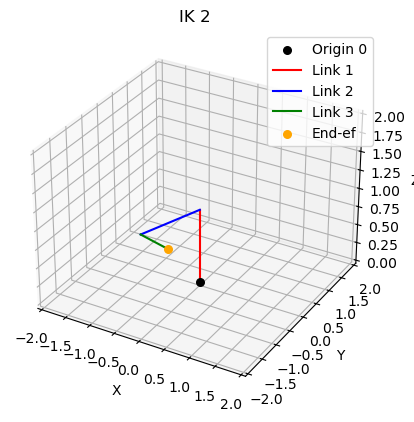

End ef:
-0.0 -1.1 0.85


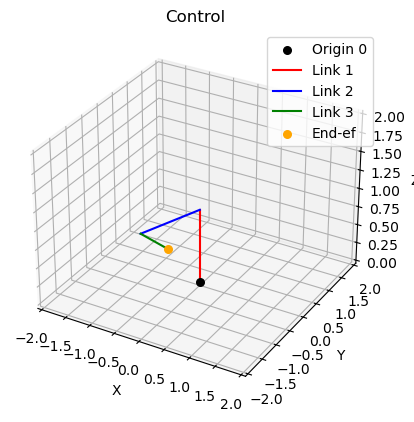

In [9]:
# Example usage
x_d, y_d, z_d = -0.0, -1.1, 0.85
L1 = 1.0
L2 = 2.0
L3 = 1.0

IK1_1, IK1_2, IK1_3, IK2_1, IK2_2, IK2_3 = inverse_kinematics_3R(x_d, y_d, z_d, L1, L2, L3)

plot_vectors_forward_kinematics(IK1_1, IK1_2, IK1_3, L1, L2, L3, 'IK 1', True)
plot_vectors_forward_kinematics(IK2_1, IK2_2, IK2_3, L1, L2, L3, 'IK 2', True)
plot_vectors_forward_kinematics(90,170, 160, L1, L2, L3, 'Control', True)

## 3.2* Numerical IK

**DISCLAIMER: For the most part of numerical IK i am blindly following functions, i am not at all experienced enough or familliar with the concepts in play to properly explain what i am doing, you can get a better grasp on the numerical solution from other sources. That said just put a "from what i understand" behind every single explanation below if you decide to continue.**

Lets try doing a numerical solution to our problem as well! Numerical solutions are far more complex and i will not delve into the details. But what we will use is an Newton-Raphson method which readjusts angles till we get to a point where we are close enough, meaning we will always have some error in our result.

To do inverse kinematics we use something called a **Jacobian matrix** , it represents how small changes in joint angles affect the end-effector position. Taking into account the partial difference $\partial$ of the position of each of the $X|Y|Z$ axis and the partial difference of $\partial$ of each joint angle. This is how the formula looks like for Robert:

$$J = \begin{bmatrix}
\frac{\partial x}{\partial θ_1} & \frac{\partial x}{\partial θ_2}  & \frac{\partial x}{\partial θ_3} \\
\frac{\partial y}{\partial θ_1} & \frac{\partial y}{\partial θ_2}  & \frac{\partial y}{\partial θ_3} \\
\frac{\partial z}{\partial θ_1} & \frac{\partial z}{\partial θ_2}  & \frac{\partial z}{\partial θ_3}
\end{bmatrix}
$$
To represent $x, y, z$ in geometrical form (they have to be a formula so we can do the partial derivative) that is useful for us when constructing the Jacobian, we will take the last column of our FK transformation matrix to represent each of them.

$$x = L_3\cos(\theta_1)\cos(\theta_2)\cos(\theta_3) - L_3\cos(\theta_1)\sin(\theta_2)\sin(\theta_3) + L_2\cos(\theta_1)\cos(\theta_2)$$
$$y = L_3\sin(\theta_1)\cos(\theta_2)\cos(\theta_3) - L_3\sin(\theta_1)\cos(\theta_2)\sin(\theta_3) + L_2\cos(\theta_1)\cos(\theta_2) $$
$$z = L_3\sin(\theta_2)\cos(\theta_3) + L_3\cos(\theta_2)\sin(\theta_3) + L_1 + L_2\sin(\theta_2) $$

And to actually fill out our jacobian matrix we have to derive from each function with respect to $\theta$, lets begin:  

$J11 = {\partial x\over \partial \theta_1}​= -L_3\sin (\theta_1)\cos (\theta_2)\cos (\theta_3)+L_3\sin (\theta_1)\sin (\theta_2)\sin (\theta_3)-L_2\sin (\theta_1)\cos (\theta_2) $

$J12 = {\partial x\over \partial \theta_2}​= -L_3\cos (\theta_1)\cos (\theta_3)\sin (\theta_2)-L_3\cos (\theta_1)\sin (\theta_3)\cos (\theta_2)-L_2\cos (\theta_1)\sin (\theta_2) $

$J13 = {\partial x\over \partial \theta_3}​= -L_3\sin (\theta_2+\theta_3)\cos (\theta_1)$

$J21 = {\partial y\over \partial \theta_1}​= -L_3\cos (\theta_2)\sin (\theta_3)\cos (\theta_1)+L_3\cos (\theta_2)\cos (\theta_3)\cos (\theta_1)-L_2\cos (\theta_2)\sin (\theta_1)$

$J22 = {\partial y\over \partial \theta_2}​= -L_3\sin (\theta_1)\sin (\theta_2)\cos (\theta_3)+L_3\sin (\theta_1)\sin (\theta_2)\sin (\theta_3)-L_2\cos (\theta_1)\sin (\theta_2) $

$J23 = {\partial y\over \partial \theta_3}​= -L_3\sin (\theta_1)\cos (\theta_2)\sin (\theta_3)-L_3\sin (\theta_1)\cos (\theta_2)\cos (\theta_3) $

$J31 = {\partial z\over \partial \theta_1}​= 0 $

$J32 = {\partial z\over \partial \theta_2}​= L_3\cos (\theta_2)\cos (\theta_3)+L_2\cos (\theta_2)-L_3\sin (\theta_2)\sin (\theta_3) $

$J33 = {\partial z\over \partial \theta_3}​= L_3\cos (\theta_2+\theta_3) $

Now we have to plug each one in the Jacobian, inverse it and we can iteratively calculate the IK, but sadly the time i have left is not enough to implement a solution, so i am leaving you on a cliffhanger. To be continued...

# Thank you for reading, it was a blast doing this!

#### By Angel Genev